In [1]:
import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt
from matplotlib import cm  # For colormap
from matplotlib.colors import Normalize
import itertools
import seaborn as sns

In [6]:
def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    r"""
    Edge-preserving, XD Anisotropic diffusion.
 
    To achieve the best effects, the image should be scaled to
    values between 0 and 1 beforehand.
 
 
    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.
 
    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.
 
    Notes
    -----
    Original MATLAB code by Peter Kovesi,
    School of Computer Science & Software Engineering,
    The University of Western Australia,
    pk @ csse uwa edu au,
    <http://www.csse.uwa.edu.au>
 
    Translated to Python and optimised by Alistair Muldal,
    Department of Pharmacology,
    University of Oxford,
    <alistair.muldal@pharm.ox.ac.uk>
 
    Adapted to arbitrary dimensionality and added to the MedPy library Oskar Maier,
    Institute for Medical Informatics,
    Universitaet Luebeck,
    <oskar.maier@googlemail.com>
 
    June 2000  original version. -
    March 2002 corrected diffusion eqn No 2. -
    July 2012 translated to Python -
    August 2013 incorporated into MedPy, arbitrary dimensionality -
 
    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:
 
        def condgradient(delta, spacing):
            return np.exp(-((delta / kappa) ** 2.0)) / float(spacing)
 
    elif option == 2:
 
        def condgradient(delta, spacing):
            return 1.0 / (1.0 + (delta / kappa) ** 2.0) / float(spacing)
 
    elif option == 3:
        kappa_s = kappa * (2**0.5)
 
        def condgradient(delta, spacing):
            top = 0.5 * ((1.0 - (delta / kappa_s) ** 2.0) ** 2.0) / float(spacing)
            return np.where(np.abs(delta) <= kappa_s, top, 0)
 
    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)
 
    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.0] * img.ndim)
 
    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]
 
    for _ in range(niter):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = tuple(
                [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            )
            deltas[i][tuple(slicer)] = np.diff(out, axis=i)
 
        # update matrices
        matrices = [
            condgradient(delta, spacing) * delta
            for delta, spacing in zip(deltas, voxelspacing)
        ]
 
        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = tuple(
                [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            )
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)
 
        # update the image
        out += gamma * (np.sum(matrices, axis=0))
 
    return out

def skel_unique(img):
    # Main loop for initial pass at skeletonization
    skel = np.zeros(img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
    while True:
        open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
        temp = cv2.subtract(img, open_img)                            # Subtracts the above from the original image
        temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
        skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
        img = cv2.erode(img, element)                     # degrades the width of the image by 1 pixel
        if cv2.countNonZero(img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
            break
    return skel

def find_tips(skel_img):
    kernel = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]], dtype=np.uint8)
    neighbors = cv2.filter2D(skel_img, -1, kernel)
    tips = (neighbors == 11).astype(np.uint8) * 255
    return tips

def cos_sim(vectors):
    smallest_similarity = float('inf')
    smallest_pair = None
    
    # Generate all combinations of two vectors
    for (key1, vec1), (key2, vec2) in itertools.combinations(vectors.items(), 2):
        # Compute cosine similarity as the dot product (vectors are normalized)
        similarity = np.dot(vec1[0], vec2[0])
        
        # Check if this is the smallest similarity so far
        if similarity < smallest_similarity:
            smallest_similarity = similarity
            smallest_pair = (key1, key2)
    
    return smallest_similarity, smallest_pair

class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            self.parent[root_y] = root_x

def sort_by_proximity(contour_points, branch_point):
    """
    Sorts a list of points (from cv2.findContours) starting from the point closest to the branch point.
    Then it orders the remaining points based on nearest-neighbor proximity.

    Parameters:
        contour_points (numpy.ndarray): Array of points of shape (n, 1, 2) as returned by cv2.findContours.
        branch_point (tuple or np.ndarray): The (x, y) coordinate from which to anchor the sorting.

    Returns:
        numpy.ndarray: Sorted array of points of shape (n, 1, 2) with minimal distance between neighbors,
                       starting from the point closest to the branch point.
    """
    # Reshape contour points to (n, 2) for processing if needed.
    if contour_points.ndim == 3:
        contour_points = contour_points.reshape(-1, 2)

    # Remove duplicate points.
    contour_points = np.unique(contour_points, axis=0)

    # Find the point in the contour closest to the branch point.
    distances_to_branch = np.linalg.norm(contour_points - branch_point, axis=1)
    start_index = np.argmin(distances_to_branch)
    sorted_points = [contour_points[start_index]]
    contour_points = np.delete(contour_points, start_index, axis=0)

    # Greedily add the nearest neighbor.
    while len(contour_points) > 0:
        last_point = sorted_points[-1]
        distances = np.linalg.norm(contour_points - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        sorted_points.append(contour_points[nearest_idx])
        contour_points = np.delete(contour_points, nearest_idx, axis=0)

    # Return the sorted points as an array of shape (n, 1, 2)
    return np.array(sorted_points).reshape(-1, 1, 2)

class fiberL:
    def __init__(self, image, thresh_1 = 126, g_blur = 13, thresh_2 = 15):
        self.image = image    
        self.thresh_1 = thresh_1
        self.thresh_2 = thresh_2
        self.g_blur = g_blur

    def preproc(self):
        if self.image is not None:
            # Convert to grayscale
            gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

            self.diff_img = anisotropic_diffusion(gray_image, niter=50, kappa=20, gamma=0.1, option=1)

            # Apply initial threshold
            _, self.binary_image = cv2.threshold(self.diff_img, self.thresh_1, 255, cv2.THRESH_BINARY)

            # Apply Initial Skeletonization
            self.skel1 = skel_unique(self.binary_image)

            # Apply Gaussian blur
            self.blurred_image = cv2.GaussianBlur(self.skel1, (self.g_blur, self.g_blur), 0)

            # Apply secondary threshold
            _, self.final_binary = cv2.threshold(self.blurred_image, self.thresh_2, 255, cv2.THRESH_BINARY)

            # Apply final Skeletonization
            self.sk_image = morphology.skeletonize(self.final_binary > 0).astype(np.uint8)

    def branch(self, size_min = 5):
        """Identify segments and nodes in a skeletonized image.
        """
        skel_img = self.sk_image.copy()
        # Define the branch point detection kernels

        t1 = np.array([[-1, 1, -1],
                    [1, 1, 1],
                    [-1, -1, -1]], dtype=np.int8)
        t2 = np.array([[1, -1, 1],
                    [-1, 1, -1],
                    [1, -1, -1]], dtype=np.int8)
        y1 = np.array([[1, -1, 1],
                    [0, 1, 0],
                    [0, 1, 0]], dtype=np.int8)
        y2 = np.array([[-1, 1, -1],
                    [1, 1, 0],
                    [-1, 0, 1]], dtype=np.int8)

        plus = np.array([[-1,  1, -1],
                    [ 1,  1,  1],
                    [-1,  1, -1]], dtype=np.int8)

        # Rotate the kernels to cover all orientations

        self.kernels =  ([t1, np.rot90(t1, 1), np.rot90(t1, 2), np.rot90(t1, 3)] + 
                    [t2, np.rot90(t2, 1), np.rot90(t2, 2), np.rot90(t2, 3)] + 
                    [y1, np.rot90(y1, 1), np.rot90(y1, 2), np.rot90(y1, 3)] + 
                    [y2, np.rot90(y2, 1), np.rot90(y2, 2), np.rot90(y2, 3)] + 
                    [plus])
        
        # Create an empty image to store branch points
        self.branch_pts_img = np.zeros(skel_img.shape, dtype=np.uint8)

        # Apply each kernel with morphological hit-or-miss operation
        for k in self.kernels:
            hit_miss = cv2.morphologyEx(src=skel_img, op=cv2.MORPH_HITMISS, kernel=k, borderType=cv2.BORDER_CONSTANT, borderValue=0)
            self.branch_pts_img = cv2.bitwise_or(self.branch_pts_img, hit_miss)
        branch_pts = np.argwhere(self.branch_pts_img != 0)

        # 2) Dilate branch points and subtract them from the skeleton
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
        self.bp = cv2.dilate(self.branch_pts_img, kernel, iterations=1)
        branch_pts = np.array([[pt[1], pt[0]] for pt in branch_pts])  # Convert (y,x) -> (x,y)
        
        self.detached = cv2.subtract(skel_img, self.bp)

        contours, _ = cv2.findContours(self.detached, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
        kept_segments = []
        deleted_segments = []
        for contour in contours:
            arc_length = cv2.arcLength(contour, closed=False)  # Arc length
            point_count = len(contour)  # Number of points
            
            # Check BOTH conditions: minimum points and arc length
            if point_count > size_min and arc_length > size_min:
                kept_segments.append(contour)  # Keep valid contours
            else:
                deleted_segments.append(contour)  # Remove invalid contours
                # Remove small segments from the skeleton
                for point in contour:
                    skel_img[point[0][1], point[0][0]] = 0
        tips = find_tips(skel_img)

        # Only keep edges with >= 5 points
        edge_objects = [edge for edge in kept_segments if len(edge) >= 5]
        print(f"Removed {len(deleted_segments)} small contours (less than {size_min} points or arc length) and kept {len(edge_objects)} contours")
        edge_points_list = [np.array([point[0] for point in edge]) for edge in edge_objects]

        self.skel_img, self.branch_pts, self.edge_points_list, self.tips = skel_img, branch_pts, edge_points_list, tips
    
    def intersection_associate(self, proximity_threshold=15):
        """
        Calculate intersection associations by finding nearby edges for each branch point.

        Args:
            br_pts: List of branch points (x, y).
            edge_points_list: List of edge points for all edges.
            proximity_threshold: Maximum distance for association.

        Returns:
            intersection_associations: A dictionary mapping branch point indices to associated edge indices.
        """
        intersection_associations = {}
        for br_index, br_point in enumerate(self.branch_pts):
            associated_edges = []
            for edge_index, edge_points in enumerate(self.edge_points_list):
                # Ensure edge_points has shape (n, 2)
                if edge_points.ndim == 1:
                    edge_points = edge_points.reshape(-1, 2)
                
                # Calculate distances from branch point to all points in the edge
                distances = np.linalg.norm(edge_points - br_point, axis=1)
                min_distance = np.min(distances)

                # Check proximity
                if min_distance <= proximity_threshold:
                    associated_edges.append(edge_index)

            intersection_associations[br_index] = associated_edges
        self.int_assoc = intersection_associations    

    def edge_connect(self):
        """
        Calculate edge connections based on cosine similarity to identify the most aligned pair of edges.
        """

        branch_connections = {}

        for br_index, associated_edges in self.int_assoc.items():
            #print(f"Branch Point {br_index} associated edges: {associated_edges}")
            vectors = {}
            edge_count = len(associated_edges)
            smallest_pair = None
            for edge_index in associated_edges:
                edge_points = sort_by_proximity(self.edge_points_list[edge_index], self.branch_pts[br_index])
                # Check edge length and skip invalid ones
                if len(edge_points) < 5:
                    # print(f"Skipping edge {edge_index} due to insufficient points: length={len(edge_points)}")
                    continue

                last_idx = len(edge_points) - 1
                close_idx = np.argmin(np.linalg.norm(edge_points - self.branch_pts[br_index], axis=2))

                if close_idx == 0:
                    print("close index is: ", close_idx)
                    v = np.linalg.norm(edge_points[0] - edge_points[4])
                    vectors[edge_index] = (edge_points[0] - edge_points[4]) / v
                elif close_idx == last_idx:
                    print("close index is: ", last_idx)
                    v = np.linalg.norm(edge_points[last_idx] - edge_points[last_idx - 4])
                    vectors[edge_index] = (edge_points[last_idx] - edge_points[last_idx - 4]) / v
                else:
                    near_dist = np.linalg.norm(edge_points[close_idx - 1])
                    far_dist = np.linalg.norm(edge_points[close_idx + 1])
                    print("near_dist: ", near_dist, "far_dist: ", far_dist)
                    if near_dist < far_dist and close_idx >= 4:
                        v = np.linalg.norm(edge_points[close_idx] - edge_points[close_idx - 4])
                        vectors[edge_index] = (edge_points[close_idx] - edge_points[close_idx - 4]) / v
                    elif close_idx + 4 < len(edge_points):
                        v = np.linalg.norm(edge_points[close_idx] - edge_points[close_idx + 4])
                        vectors[edge_index] = (edge_points[close_idx] - edge_points[close_idx + 4]) / v
                print(vectors[edge_index])
            
            # Find the smallest cosine similarity
            while edge_count > 1:
                _, smallest_pair = cos_sim(vectors)
                print(cos_sim(vectors)[1])
                if smallest_pair:
                    if br_index not in branch_connections:
                        branch_connections[br_index] = []
                    
                    # Append the new pair instead of overwriting
                    branch_connections[br_index].append(smallest_pair)

                    # Remove those vectors from the dictionary
                    del vectors[smallest_pair[0]]
                    del vectors[smallest_pair[1]]
                    edge_count -= 2
        self.branch_connections = branch_connections

    def merge_edges(self):
        if not self.branch_connections:
            self.edges = self.edge_points_list  # Ensure self.edges is always set
            return

        uf = UnionFind()
        # branch_connections[br_index] is a list of pairs like (edgeA, edgeB)
        for pair_list in self.branch_connections.values():
            for (edge1, edge2) in pair_list:
                # Union the two integer indices
                uf.union(edge1, edge2)

        grouped_edges = {}
        for idx, edge in enumerate(self.edge_points_list):
            root = uf.find(idx)
            if root not in grouped_edges:
                grouped_edges[root] = []
            grouped_edges[root].append(edge)

        new_edge_objects = []
        for group_edges in grouped_edges.values():
            concatenated = group_edges[0]
            for next_edge in group_edges[1:]:
                # Check orientation before concatenating
                if np.linalg.norm(concatenated[-1] - next_edge[0]) > 1:
                    next_edge = np.flip(next_edge, axis=0)
                concatenated = np.vstack((concatenated, next_edge))
            new_edge_objects.append(concatenated.reshape(-1, 1, 2))

        self.edges = new_edge_objects

    def viz_and_sum(self, thickness=2):
        """
        Draw edge objects on a blank image with color based on arc length.
        """
        # Compute arc lengths
        self.arc_lengths = [cv2.arcLength(edge, closed=False) for edge in self.edges]

        # Normalize arc lengths to range [0, 1]
        norm = Normalize(vmin=min(self.arc_lengths), vmax=max(self.arc_lengths))
        colormap = cm.plasma  # Choose a colorful colormap ('plasma', 'viridis', etc.)

        # Create a blank image
        color_image = np.zeros((self.skel_img.shape[0], self.skel_img.shape[1], 3), dtype=np.uint8)

        for edge, length in zip(self.edges, self.arc_lengths):
            # Get RGBA color from the colormap and convert to RGB
            color_value = colormap(norm(length))
            color = tuple(int(c * 255) for c in color_value[:3])  # Convert to RGB

            # Convert edge points to integers
            if not isinstance(edge, np.ndarray):
                continue  # Skip invalid edges
            edge = edge.astype(np.int32)

            # Draw the edge on the blank image
            cv2.polylines(color_image, [edge], isClosed=False, color=color, thickness=thickness, lineType=cv2.LINE_AA)
        
        self.color_image = color_image

        fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

        # Left: colored edge network
        axes[0].imshow(self.color_image)
        axes[0].set_title("Final Colored Edge Network")
        axes[0].axis('off')

        # Middle: histogram + KDE
        sns.histplot(self.arc_lengths, bins=20, ax=axes[1], kde=True,
                    color='steelblue', edgecolor='black')
        axes[1].set_title("Density and Histogram of Arc Lengths")
        axes[1].set_xlabel("Arc Length")
        axes[1].set_ylabel("Density / Frequency")

        # Right: box plot
        sns.boxplot(self.arc_lengths, ax=axes[2], color='lightblue')
        axes[2].set_title("Boxplot of Arc Lengths")
        axes[2].set_xlabel("Arc Length")

        # Overall figure title
        avg_length = np.mean(self.arc_lengths) if len(self.arc_lengths) > 0 else 0
        fig.suptitle(f"Average Fiber Length: {avg_length:.2f}", fontsize=16)

        # Actually show the figure now
        plt.show()

        self.fig = fig
        self.axes = axes

    def find_length(self):
        """
        Computes edges from skeleton, merges them, calculates arc lengths,
        creates a color image, and then calls `visualize_results` to show everything.
        Returns the raw data if you want it.
        """
        # 1) Preprocess
        self.preproc()

        # 2) Find branch points
        self.branch()

        # 3) Associate segments to branch points
        self.intersection_associate(proximity_threshold=5)

        # 4) Segment to segment logic at each node
        self.edge_connect()

        # 5) Merge edges
        self.merge_edges()

        # 6) Show final figure: output fiber length + color map + histogram + boxplot
        self.viz_and_sum()

Removed 0 small contours (less than 5 points or arc length) and kept 4 contours
close index is:  0
[[ 0. -1.]]
close index is:  0
[[1. 0.]]
close index is:  0
[[-1.  0.]]
close index is:  0
[[0. 1.]]
(0, 3)
(1, 2)


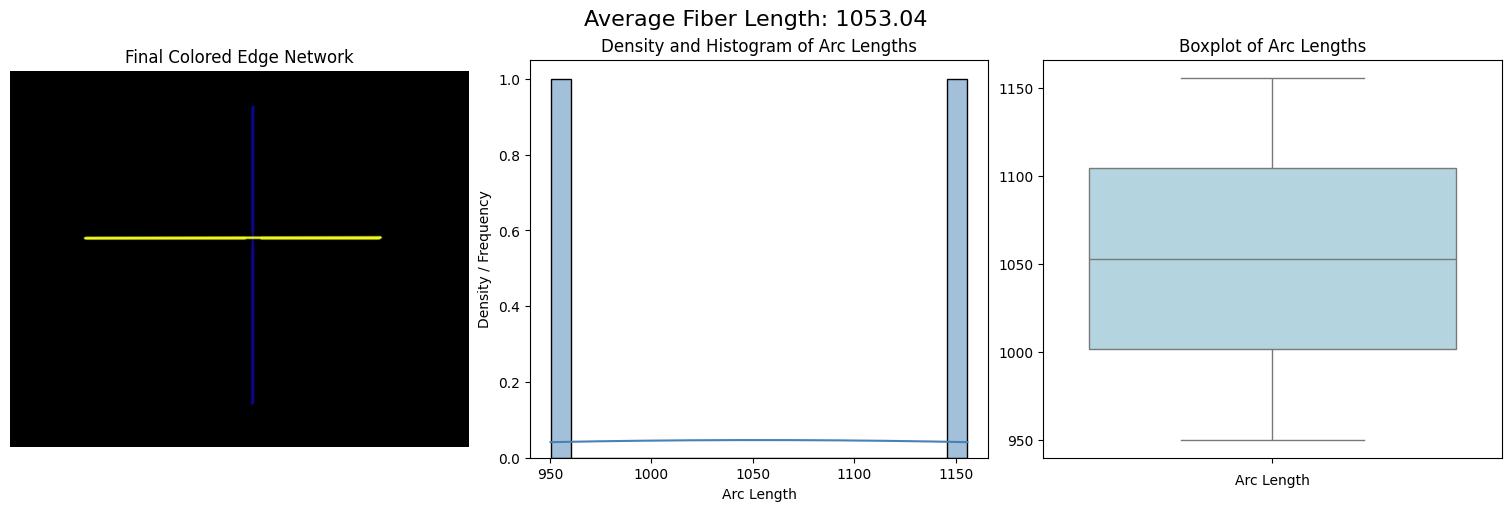

In [11]:
test = cv2.imread('test2.tif')
img = fiberL(test)
img.preproc()
img.branch()
img.intersection_associate()
img.edge_connect()
img.merge_edges()
img.viz_and_sum()

Removed 0 small contours (less than 5 points or arc length) and kept 4 contours


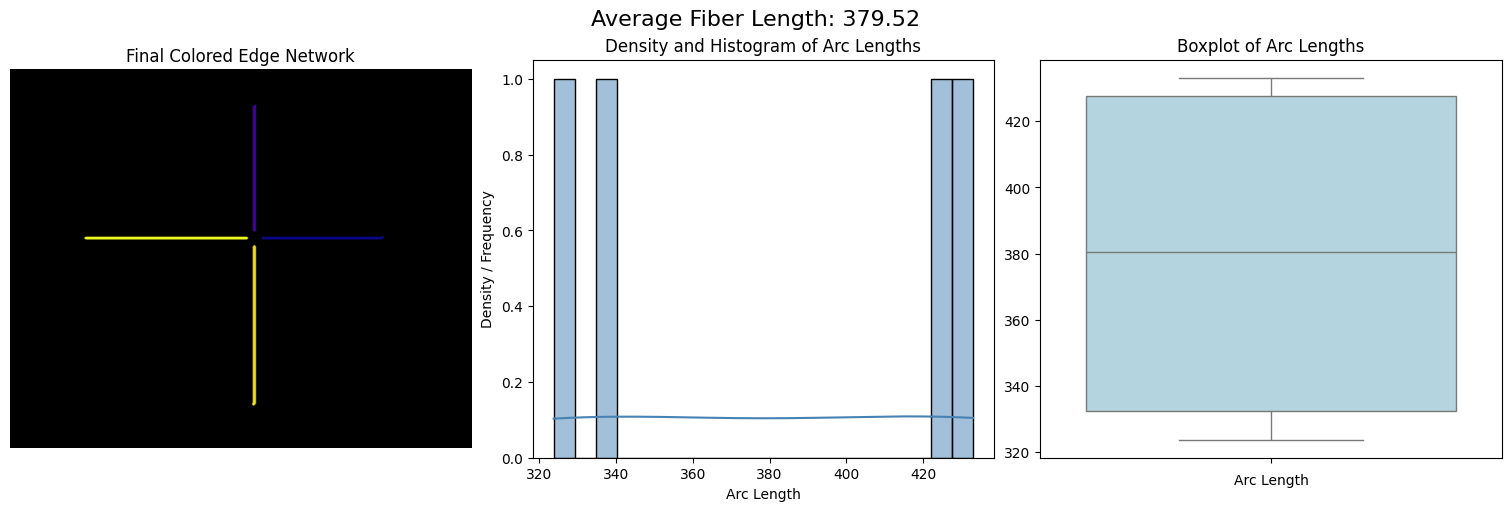

In [12]:
test = cv2.imread('test2.tif')
img = fiberL(test)
img.find_length()

Removed 0 small contours (less than 5 points or arc length) and kept 9 contours
close index is:  0
[[ 0.70710678 -0.70710678]]
close index is:  0
[[0.89442719 0.4472136 ]]
close index is:  0
[[-0.4472136   0.89442719]]
(4, 8)
close index is:  0
[[ 0.70710678 -0.70710678]]
close index is:  0
[[-0.9701425  -0.24253563]]
close index is:  0
[[-0.4472136   0.89442719]]
(4, 8)
close index is:  0
[[ 0.9701425  -0.24253563]]
close index is:  0
[[0.70710678 0.70710678]]
close index is:  0
[[-0.24253563  0.9701425 ]]
(2, 6)
close index is:  0
[[-0.24253563  0.9701425 ]]
close index is:  0
[[ 0.4472136  -0.89442719]]
close index is:  0
[[0.89442719 0.4472136 ]]
close index is:  0
[[-0.6  0.8]]
(0, 4)
close index is:  0
[[ 0.4472136  -0.89442719]]
close index is:  0
[[-0.9701425  -0.24253563]]
close index is:  0
[[-0.6  0.8]]
(0, 4)


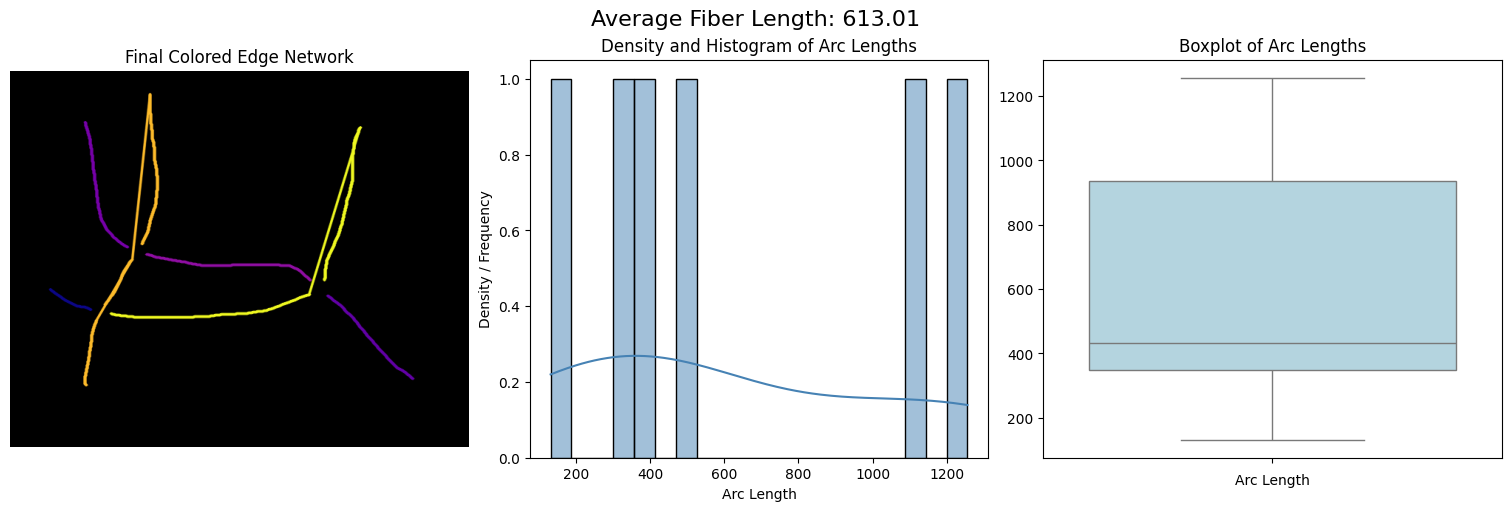

In [116]:
test2 = cv2.imread('test3.tif')
img2 = fiberL(test2)
img2.preproc()
img2.branch()
img2.intersection_associate()
img2.edge_connect()
img2.merge_edges()
img2.viz_and_sum()